In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from string import ascii_lowercase
import requests
import random

In [2]:
# get list of words
words = requests.get(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
    ).text.splitlines()
print(f'{len(words)=}')
print(f'{words[:5]=}')

len(words)=32033
words[:5]=['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# integer mappings of characters
chars = ascii_lowercase
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# number of characters including '.'
char_total = 27
# number of previous characters to consider for prediction
block_size = 3
# chosen dimensionality of characters
char_dim = 2

In [5]:
# build the dataset

X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
# each of char_total characters will have a char_dim-dimensional embedding
C = torch.randn(char_total, char_dim)

In [7]:
# retrieve char_dim-dimensional vectors for every char_total character embedding in X
emb = C[X]

In [8]:
print(f'{C.shape=}')
print(f'{X.shape=}')
print(f'{emb.shape=}')

C.shape=torch.Size([27, 2])
X.shape=torch.Size([32, 3])
emb.shape=torch.Size([32, 3, 2])


In [9]:
# number of neurons in each layer
layer1_size = 100

In [10]:
# weights & biases of first layer
# weights are block_size * char_dim
# biases are scalars
W1 = torch.randn((block_size*char_dim, layer1_size))
b1 = torch.randn(layer1_size)

We want to perform `emb @ W1 + b1`, but we cannot matrix multiply `[228146, 3, 4]` by `[6, 100]`. We need a way to concatenate the embedding into a smaller space.

The theory is to break out each character in block_size, like `[emb[:, 0, :], emb[:, 1, :] ..., emb[:, n, :]`. The `torch.unbind()` function works here, but `<tensor>.view()` works even better.

(`.view()` works even better because it just manipulates the "view" of the underlying storage of the tensor, which is just all the numbers in the tensor. concatenate & unbind create an entirely new tensor, which requires a lot of new memory.)

In [11]:
# unbind embedding at the embedding's block_size dimension
# 2nd dimension (block size of 3) indexed at 1

# compare .view() to unbind & concat
torch.all(emb.view(emb.shape[0], emb.shape[1]*emb.shape[2]) == torch.cat(torch.unbind(emb, 1), 1))

tensor(True)

In [12]:
# multiply embedding by weights & biases in first layer
l1 = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2]) @ W1 + b1
print(f'{l1.shape=}')

l1.shape=torch.Size([32, 100])


In [13]:
# weights & biases of output layer
W2 = torch.randn(layer1_size, char_total)
b2 = torch.randn(char_total)

In [14]:
# output layer (logits)
logits = l1 @ W2 + b2
print(f'{logits.shape=}')
# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
print(f'{prob.shape=}')

logits.shape=torch.Size([32, 27])
prob.shape=torch.Size([32, 27])


In [15]:
# loss function (average negative log likelihood)
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
print(f'{loss=}')

loss=tensor(inf)


Review

In [16]:
print(f'{X.shape=}')
print(f'{Y.shape=}')

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((char_total, char_dim), generator=g)
W1 = torch.randn((char_dim*block_size, layer1_size), generator=g)
b1 = torch.randn(layer1_size, generator=g)
W2 = torch.randn((layer1_size, char_total), generator=g)
b2 = torch.randn(char_total, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f'{C.shape=}')
print(f'{W1.shape=}')
print(f'{b1.shape=}')
print(f'{W2.shape=}')
print(f'{b2.shape=}')
print('Parameter total:', sum(p.nelement() for p in parameters))

emb = C[X]
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
print(f'{emb.shape=}')
print(f'{l1.shape=}')
print(f'{logits.shape=}')
print(f'{counts.shape=}')
print(f'{prob.shape=}')
print(f'{loss=}')

X.shape=torch.Size([32, 3])
Y.shape=torch.Size([32])
C.shape=torch.Size([27, 2])
W1.shape=torch.Size([6, 100])
b1.shape=torch.Size([100])
W2.shape=torch.Size([100, 27])
b2.shape=torch.Size([27])
Parameter total: 3481
emb.shape=torch.Size([32, 3, 2])
l1.shape=torch.Size([32, 100])
logits.shape=torch.Size([32, 27])
counts.shape=torch.Size([32, 27])
prob.shape=torch.Size([32, 27])
loss=tensor(17.7697)


Converting the logits to loss manually is reinventing the wheel. We can use torch's `.cross_entropy()` to do exactly this.

In [17]:
cross_entropy_loss = F.cross_entropy(logits, Y)
print(f'{cross_entropy_loss=}')

cross_entropy_loss=tensor(17.7697)


In [18]:
# all parameters require a gradient (to tune)
for p in parameters:
    p.requires_grad = True

In [19]:
# define learning rate
lr = 0.4

In [20]:
# redefine X and Y to include entire dataset

X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [21]:
# define batch size for training
batch_size = 32

In [22]:
lre = torch.linspace(-3, 0, 1000) # linear learning rate linspace
lrs = 10**lre # exponential instead of linear change in learning rate

lri = []
lossi = []
for i in range(1000):
    # construct minibatch
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # forward pass
    emb = C[X[ix]]
    l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
    logits = l1 @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
#print(f'{loss.item()=}')

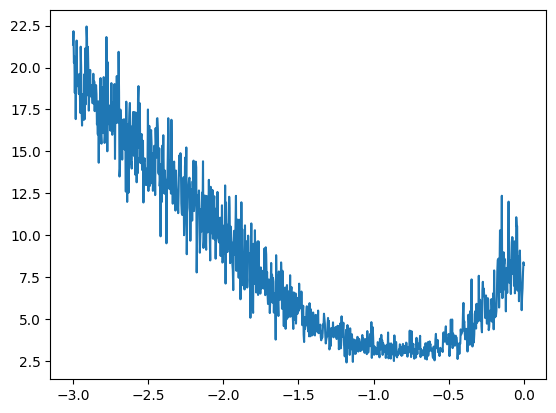

In [23]:
plt.plot(lri, lossi)

In [24]:
# checking loss on entire dataset
emb = C[X]
# -1 in emb.view() instructs torch to infer the actual dimension from the others
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f'{loss=}')

loss=tensor(8.4358, grad_fn=<NllLossBackward0>)


train/val/test split <br>
80%, 10%, 10% <br>
train: for optimizing parameters of model <br>
validation: for development of the hyperparameters of the model <br>
test: evaluate true performance of model <br>

In [39]:
# build dataset with splits
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [40]:
# training, val, and testing dataset sizes
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [31]:
# training model on training data

lri = []
lossi = []
for i in range(10000):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
    logits = l1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
#print(f'{loss.item()=}')

In [34]:
# training
emb = C[Xtr]
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.4175190925598145


In [33]:
# validation
emb = C[Xdev]
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.4131875038146973


Our training and validation scores are roughly equal, so our model is underfitting. It is not powerful enough to memorize the training data. Let's increase the size of the network so that our model has a better understanding of the training data, but can still generalize to the validation data.

In [45]:
# increasing size of model

layer1_size = 300

C = torch.randn((char_total, char_dim), generator=g)
W1 = torch.randn((char_dim*block_size, layer1_size), generator=g)
b1 = torch.randn(layer1_size, generator=g)
W2 = torch.randn((layer1_size, char_total), generator=g)
b2 = torch.randn(char_total, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f'{C.shape=}')
print(f'{W1.shape=}')
print(f'{b1.shape=}')
print(f'{W2.shape=}')
print(f'{b2.shape=}')
print('Parameter total:', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

C.shape=torch.Size([27, 2])
W1.shape=torch.Size([6, 300])
b1.shape=torch.Size([300])
W2.shape=torch.Size([300, 27])
b2.shape=torch.Size([27])
Parameter total: 10281


In [61]:
# lri = []
lossi = []
stepi = []
lr = 0.01
for i in range(30000):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
    logits = l1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
#print(f'{loss.item()=}')

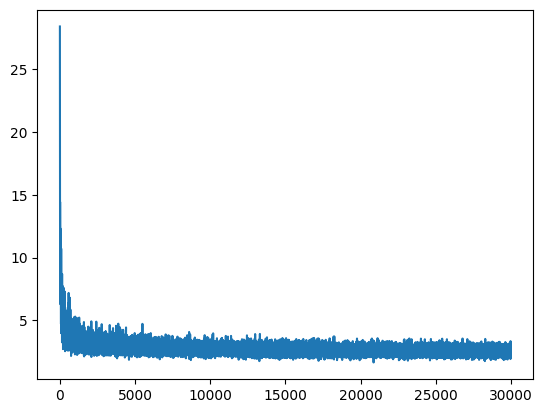

In [47]:
plt.plot(stepi, lossi)

In [48]:
tr_losses = []
dev_losses = []

In [62]:
# training
emb = C[Xtr]
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
trloss = F.cross_entropy(logits, Ytr)
tr_losses.append((lr, trloss))
print(f'{trloss.item()=}')

# validation
emb = C[Xdev]
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
devloss = F.cross_entropy(logits, Ydev)
dev_losses.append((lr, devloss))
print(f'{devloss.item()=}')

trloss.item()=2.2305052280426025
devloss.item()=2.2615129947662354


In [67]:
for i in range(len(tr_losses)):
    print('tr', tr_losses[i][0], tr_losses[i][1].item())
    print('dev', dev_losses[i][0], dev_losses[i][1].item())

tr 0.1 2.583890199661255
dev 0.1 2.598050117492676
tr 0.1 2.5059657096862793
dev 0.1 2.5342464447021484
tr 0.05 2.3206613063812256
dev 0.05 2.3477091789245605
tr 0.05 2.3065757751464844
dev 0.05 2.3350274562835693
tr 0.02 2.252927541732788
dev 0.02 2.2842824459075928
tr 0.02 2.250760793685913
dev 0.02 2.280562162399292
tr 0.01 2.2305052280426025
dev 0.01 2.2615129947662354


The losses, though similar, are now lower for the dev set. The network is better fitting to the training data. It's probable that the bottleneck for accuracy is now the embedding vector (the input dimensions are too low). Let's increase the number of dimensions to represent a character.

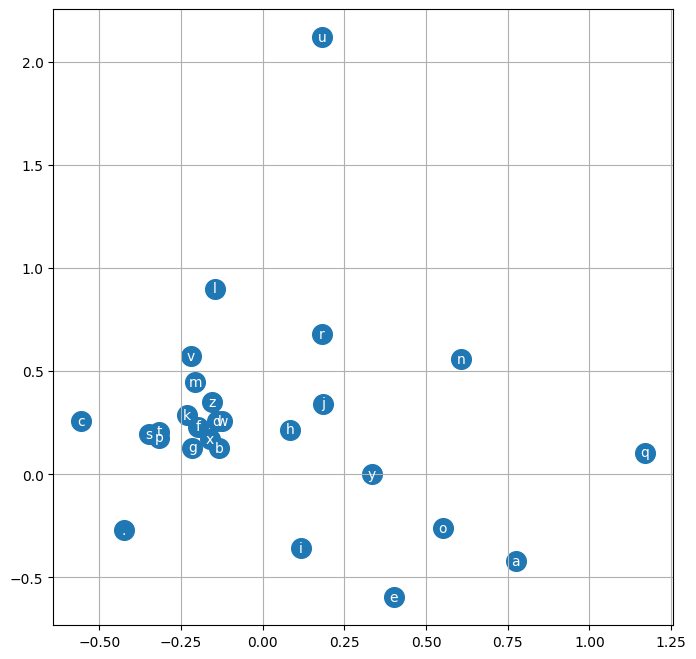

In [69]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [72]:
# increasing total character dimensions
# decreasing network size

char_dim = 10
layer1_size = 200

C = torch.randn((char_total, char_dim), generator=g)
W1 = torch.randn((char_dim*block_size, layer1_size), generator=g)
b1 = torch.randn(layer1_size, generator=g)
W2 = torch.randn((layer1_size, char_total), generator=g)
b2 = torch.randn(char_total, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f'{C.shape=}')
print(f'{W1.shape=}')
print(f'{b1.shape=}')
print(f'{W2.shape=}')
print(f'{b2.shape=}')
print('Parameter total:', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

C.shape=torch.Size([27, 10])
W1.shape=torch.Size([30, 200])
b1.shape=torch.Size([200])
W2.shape=torch.Size([200, 27])
b2.shape=torch.Size([27])
Parameter total: 11897


In [73]:
tr_losses = []
dev_losses = []

In [74]:
lossi = []
stepi = []

In [81]:
# lri = []
lr = 0.01
for i in range(50000):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
    logits = l1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    # lri.append(lre[i])
    stepi.append(i+100_000)
    lossi.append(loss.log10().item())
#print(f'{loss.item()=}')

In [82]:
# training
emb = C[Xtr]
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
trloss = F.cross_entropy(logits, Ytr)
tr_losses.append((lr, trloss))
print(f'{trloss.item()=}')

# validation
emb = C[Xdev]
l1 = torch.tanh(emb.view(-1, char_dim*block_size) @ W1 + b1)
logits = l1 @ W2 + b2
devloss = F.cross_entropy(logits, Ydev)
dev_losses.append((lr, devloss))
print(f'{devloss.item()=}')

trloss.item()=2.1682283878326416
devloss.item()=2.2131683826446533


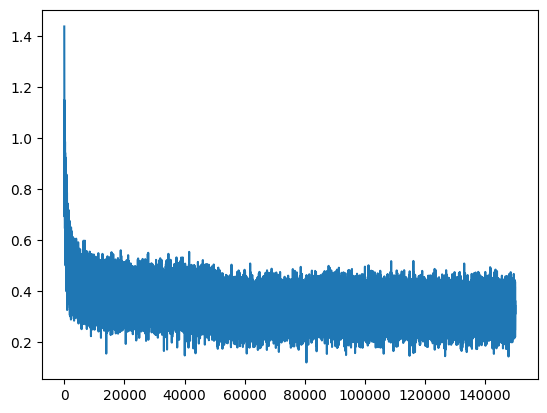

In [83]:
plt.plot(stepi, lossi)

In [84]:
for i in range(len(tr_losses)):
    print('tr', tr_losses[i][0], tr_losses[i][1].item())
    print('dev', dev_losses[i][0], dev_losses[i][1].item())

tr 0.1 2.3192052841186523
dev 0.1 2.3631107807159424
tr 0.01 2.1737899780273438
dev 0.01 2.2142884731292725
tr 0.01 2.1682283878326416
dev 0.01 2.2131683826446533


In [85]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(15):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      l1 = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = l1 @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
gryanniellend.
ryalerethrisendraege.
zeredielin.
shi.
jenleigh.
can.
narleiyah.
hona.
cayshabergahirael.
janie.
jelippe.
paisou.
zayven.
jylene.
